In [3]:
from pathlib import Path
import math
import textwrap
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import geopandas as gpd
import numpy as np
import scipy
import lmfit

# local imports
# from src.db.config import CONFIG_DATASTORE as config_datastore
# from src.db.config import CONFIG_ANALYSES as config_analyses
# from dbconnection import DBConnection
# from dbanalysis import DataAnalysis
# preparing databases 
# db_conn_datastore = DBConnection(config_datastore).get_connection()
# db_conn_analyses = DBConnection(config_analyses).get_connection()
# data_analysis = DataAnalysis(db_conn_datastore, db_conn_analyses)

# plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

In [10]:
file_paths = {
    'goat_survey': Path('/app/src/data/input/survey_goat_3/Ergebnisse/results-survey461849_fragencode_antwortcodes.csv'),
    'goat_survey_metadata': Path('/app/src/data/input/survey_goat_3/Ergebnisse/Umfrage_Codebook.xlsx'),
}

In [11]:
# data imports

# importing goat 3.0 survey results
survey_goat = pd.read_csv(file_paths['goat_survey'], sep=';')

# importing goat 3.0 survey metadata and fill holes in all columns except 'Vollständige Antwort' and 'Antwortcode' with the last value above
survey_goat_metadata = pd.read_excel(file_paths['goat_survey_metadata'])
survey_goat_metadata.loc[:,~survey_goat_metadata.columns.isin(['Vollständige Antwort', 'Antwortcode'])] = survey_goat_metadata.loc[:,~survey_goat_metadata.columns.isin(['Vollständige Antwort', 'Antwortcode'])].fillna(method='ffill')


In [47]:
def plot_distribution_answers(col, ax, df, df_metadata, fragecode):
    """ This function plots the distribution of the responses for a given question (column) of the survey DataFrame.        

    Args:
        col (string): column of the survey DataFrame that will be plotted
        ax (Axes object): axes object to plot on
        df (pandas DataFrame): a DataFrame containing the survey results
        df_metadata (pandas DataFrame): a DataFrame containing the survey metadata

    Returns:
        Axes object: Axes object with the plot drawn onto it
    """
    sns.barplot(
        ax=ax, data=df[col].replace(np.nan, 'N').value_counts().reset_index().rename(columns={col: 'Antwortcode'}).sort_values(by = 'Antwortcode').reset_index(drop=True), x='Antwortcode', y='count', 
        order=df_metadata[df_metadata['Fragencode']==col]['Antwortcode'].replace(np.nan, 'N')
    )
    ax.set(title=df_metadata[df_metadata['Fragencode']==col]['Variable'].iloc[0], ylabel='Anzahl', xticklabels = [textwrap.fill(label, 23) for label in df_metadata[df_metadata['Fragencode']==col]['Vollständige Antwort']])
    ax.tick_params(labelrotation=60, pad=3)
    ax.xaxis.label.set_visible(False)
    ax.text(0.775, 0.95, f"n: {df['id'].nunique()}", transform=ax.transAxes, ha='right', fontsize=8)     
    
    if fragecode == 'reisezeit':
        # adding the weighted average travel times to the plots (a little bit wrong as e.g. A7 indicates greater than 25 min) 
        given_answers = pd.DataFrame(df[col][df[col]!='A8'].value_counts().rename('counts').sort_index()) #except A8
        travel_times = {'A1':0, 'A2':5, 'A3':10, 'A4':15, 'A5':20, 'A6':25, 'A7':30} 
        given_answers['travel_times'] = given_answers.index.map(travel_times.get)
        ax.text(0.95, 0.9, f"Ø Reisezeit: {round((given_answers['travel_times'] * given_answers['counts']).sum() / given_answers['counts'].sum())} min", transform=ax.transAxes, ha='right', fontsize=8)
        
    return ax

In [13]:
def plot_ecdf_answers(col, ax, df, df_metadata):
    """ This function plots an complementary emprical cummulative distribution plot of the responses for a given question (column) of the survey DataFrame.

    Args:
        col (string): column of the survey DataFrame that will be plotted
        ax (Axes object): axes object to plot on
        df (pandas DataFrame): a DataFrame containing the survey results
        df_metadata (pandas DataFrame): a DataFrame containing the survey metadata

    Returns:
        Axes object: Axes object with the plot drawn onto it
    """
    sns.ecdfplot(ax=ax, data=df[col][df[col]!='A8'].sort_values(), complementary=True)
    ax.set(title=df_metadata[df_metadata['Fragencode']==col]['Variable'].iloc[0], ylabel='Prozent', xticks = df_metadata[df_metadata['Fragencode']==col]['Antwortcode'],
    xticklabels = df_metadata[df_metadata['Fragencode']==col]['Vollständige Antwort'])
    ax.tick_params(labelrotation=90)
    ax.xaxis.label.set_visible(False)
    return ax

In [14]:
# helper functions to create the modified Gauß plots

###
# Define your series
def get_stats_df(col, df, df_metadata):
    """This function computes the count, the pdf (probability density function) values and the complementary cdf (cummulative density function) values 
        of the responses for a given question (column) of the survey DataFrame.

    Args:
        col (string): column of the survey DataFrame that will be analysed
        df (pandas DataFrame): a DataFrame containing the survey results

    Returns:
        pandas DataFrame: contains the different the answer codes, the count of the answers, the pdf values and the complementary cdf values
    """

    

    all_possible_answer_codes = df_metadata[(df_metadata['Fragencode']==col) & (df_metadata['Antwortcode'] != 'A8')]['Antwortcode'].values #except A8
    given_answer_codes = df[col][df[col]!='A8'].unique() #except A8
    not_given_answer_codes = pd.DataFrame(np.setdiff1d(all_possible_answer_codes, given_answer_codes), columns=['value']).assign(frequency=0).set_index('value')    
    
    df = pd.DataFrame(df[col][df[col]!='A8']).rename(columns = {col: 'value'}) #A8 muss noch ausgelesen/ automatisiert werden in get_stats_df
    
    stats_df = df.groupby('value')['value'].agg('count').pipe(pd.DataFrame).rename(columns = {'value': 'frequency'})   
    stats_df = pd.concat([df.stack() for df in [stats_df, not_given_answer_codes]], axis=0).unstack()

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf_complementary'] = stats_df['pdf'][::-1].cumsum()[::-1]
    stats_df = stats_df.reset_index()

    return stats_df

def modified_gaussian_fun(x, b):
    """This function calculates the corresponding y values of the modified Gauß function for a given x value and a given beta value.

    Args:
        x (numpy array): x values at which the function is evaluated 
        b (float): beta parameter of the modified Gauß function

    Returns:
        numpy array: y values of the modified Gauß function
    """    
    return np.exp(-(x**2)/b) #in Goat wird hier in Sekunden gerechnet, aber dann wieder in min geplottet

def comb_modified_gaussian_fun(x, b, a):
    """This function calculates the corresponding y values of the combined modified Gauß function for a given x value, a given beta (b) value and a given alpha (a) value. 
    Args:
        x (numpy array): x values at which the function is evaluated 
        a (integer): alpha parameter of the modified Gauß function (threshold travel time)
        b (float): beta parameter of the modified Gauß function (sensitivity parameter)       

    Returns:
        numpy array: y values of the combined modified Gauß function
    """    
    return np.piecewise(x, [x < a], [1, lambda x: np.exp(-((x-a)**2)/b)]) 


def fit_and_plot_gaussian(col, ax, df, df_metadata):
    """ This function fits the data to the modified Gaussian function and the modified Gaussian function. It then plots the responses for a given question (column) of the survey DataFrame.
    
    Args:
        col (string): column of the survey DataFrame that will be plotted
        ax (Axes object): axes object to plot on
        df (pandas DataFrame): a DataFrame containing the survey results
        df_metadata (pandas DataFrame): a DataFrame containing the survey metadata

    Returns:
        Axes object: Axes object with the plot drawn onto it
    """
    stats_df = get_stats_df(col, df, df_metadata)

    xdata = np.linspace(0, 35*60, 8, dtype = float)
    ydata = pd.concat([stats_df['cdf_complementary'], pd.Series([0])]).reset_index(drop=True)
    
    # Fit the combined modified Gaussian function
    def residual_gaussian(params, x, y):
        b = params['b'].value
        model = modified_gaussian_fun(x, b)
        return y - model  
    
    params_gaussian = lmfit.Parameters()
    params_gaussian.add('b', min=100000 , max=3000000)

    minner = lmfit.Minimizer(residual_gaussian, params_gaussian, fcn_args=(xdata, ydata))
    result = minner.minimize()

    fitB = result.params['b'].value
    
    # Fit the combined modified Gaussian function
    def residual(params, x, y):
        a = params['a'].value
        b = params['b'].value
        model = np.piecewise(x, [x < a], [1, lambda x: comb_modified_gaussian_fun(x, b, a)])
        return y - model

    params = lmfit.Parameters()
    params.add('a', min=0*5*60 , max= 3*5*60) # params.add('a', min=1.1*5*60 , max= 3*5*60) #value = 5*60
    params.add('b', min=200000 , max=3000000 )
       
    a_values = np.linspace(0, 15*60, 16) # values for constant part
    
    ### test
    # Perform the grid search
    
    # Store the results of each fit in a list
    results = []
    
    for a_val in a_values:
        params['a'].set(value=a_val, vary=False)
        
        minner = lmfit.Minimizer(residual, params, fcn_args=(xdata, ydata))
        result = minner.minimize()
        
        
        # result = lmfit.minimize(func=residual, params=params, args=(xdata, ydata))
        results.append(result)

    # Find the best fit by comparing the reduced chi-squared values
    best_result = results[0]
    for result in results[1:]:
        if result.redchi < best_result.redchi:
            best_result = result
                
    fitA_comb = best_result.params['a'].value
    fitB_comb = best_result.params['b'].value            
    
    print(f"{df_metadata[df_metadata['Fragencode']==col]['Variable'].iloc[0]}: {int(fitA_comb/60)}")            
        
    ###

    # minner = lmfit.Minimizer(residual, params, fcn_args=(xdata, ydata))
    # result = minner.minimize()

    # fitA_comb = result.params['a'].value
    # fitB_comb = result.params['b'].value
    
    # print(f'{col}: {fitA_comb}')

    ###    
    
    # calculate the fitted curve and plot it
    
    xdata_plot = np.linspace(0, 35*60, 30*60)
    
    fity_comb = comb_modified_gaussian_fun(xdata_plot, fitB_comb, fitA_comb)
    fity = modified_gaussian_fun(xdata_plot, fitB)
    
    ax.plot(xdata, ydata, '*', label='data')
    ax.plot(xdata_plot, fity_comb, '-', label='combined mod Gauß')
    ax.plot(xdata_plot, fity, '-', label='regualar mod Gauß')
    ax.set_xticks(np.linspace(0, 35*60, 8), labels = df_metadata[df_metadata['Fragencode']==col]['Vollständige Antwort'], rotation = 90)
    ax.set_title(df_metadata[df_metadata['Fragencode']==col]['Variable'].iloc[0])
    ax.plot([], [], ' ', label=f'Beta combined mod Gauß: {int(fitB_comb)}')
    ax.plot([], [], ' ', label=f'Static tt combined mod Gauß: {int(fitA_comb/60)} min')
    ax.plot([], [], ' ', label=f'Beta mod Gauß: {int(fitB)}')
    ax.legend(loc = 1, fontsize = 8)
    
    print(f"{df_metadata[df_metadata['Fragencode']==col]['Variable'].iloc[0]}: Beta combined mod Gauß: {int(fitB_comb):,}")
    # print(f"{df_metadata[df_metadata['Fragencode']==col]['Variable'].iloc[0]}: Beta mod Gauß: {int(fitB):,}")
    
    return ax

In [15]:
def create_subplots(fragecode , df, df_metadata):
    """_summary_


    Args:
        fragecode (string): The fragecode defines the survey questions subset that is plotted. For all questions the distribution based on the function plot_distribution_answers is plotted. For questions regarding the travel
            time by foot a ecdf plot (plot_ecdf_answers), the modified Gauß (fit_and_plot_gaussian) and the combined modified Gauß plot (fit_and_plot_gaussian) are plotted additionally.
        fragecodes:
            'wegeidealfuss' -> questions regarding travelling on foot
            'wegeidealrad' -> questions regarding travelling by bike
            'reisezeit' -> questions regarding travel tiems by foot
            'erreichbarkeitist' -> questions regarding the accessibility of a variety of destinations
            'haeufigkeitist' ->  questions regarding the frequency of visiting a variety of destinations
            'verkehrsmittelist' -> questions regarding the used means of transport to reach a specific destination
            'nutzungdigital' ('haeufigkeitbestellen', 'nutzungdigital' (all except nutzungdigital[other]), 'alternativedigital') -> questions regarding the use of digital services
            'wichtigkeit' ->  questions regarding the importance of a variety of destinations
            'persoenliche_informationen' ('alter', 'geschlecht', 'haushalt', 'gesundheit' (1-5), 'taetigkeit') -> questions regarding personal information of the respondents

        df (pandas DataFrame): a DataFrame containing the survey results
        df_metadata (pandas DataFrame): a DataFrame containing the survey metadata
    """
    if fragecode == 'reisezeit':

        df_plot = df[[col for col in df.columns if fragecode in col]]

        # barplots
        fig, axes = plt.subplots(nrows = math.ceil(df_plot.shape[1]/4), ncols = 4, figsize=(20, math.ceil(df_plot.shape[1]/4)*5), sharey=True, sharex = True) 
        fig.suptitle(t=f"Umfrage Goat 3.0: Antworten bzgl. {df_metadata[df_metadata['Fragencode']==f'{fragecode}[SQ001]']['Variable'].iloc[0].split()[0]}", fontsize = 20) 

        for counter, ax in enumerate(axes.flat):
            ax = plot_distribution_answers(col = df_plot.iloc[:,counter].name, ax = ax, df= df, df_metadata = df_metadata, fragecode = fragecode)
            ax.yaxis.set_tick_params(which='both', labelbottom=True)
            ax.xaxis.set_tick_params(which='both', labelbottom=True)        

        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # empirical cummulative distribution plot (ecdfplot)
        fig, axes = plt.subplots(nrows = math.ceil(df_plot.shape[1]/4), ncols = 4, figsize=(20, math.ceil(df_plot.shape[1]/4)*5), sharey=True, sharex = True) 
        fig.suptitle(t=f"Umfrage Goat 3.0: Antworten bzgl. {df_metadata[df_metadata['Fragencode']==f'{fragecode}[SQ001]']['Variable'].iloc[0].split()[0]}", fontsize = 20) 

        for counter, ax in enumerate(axes.flat):
            ax = plot_ecdf_answers(col = df_plot.iloc[:,counter].name, ax = ax, df= df, df_metadata = df_metadata)


        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # Gaussian 
        fig, axes = plt.subplots(nrows = math.ceil(df_plot.shape[1]/4), ncols = 4, figsize=(20, math.ceil(df_plot.shape[1]/4)*5), sharey=True, sharex = True) 
        fig.suptitle(t=f"Umfrage Goat 3.0: Antworten bzgl. {df_metadata[df_metadata['Fragencode']==f'{fragecode}[SQ001]']['Variable'].iloc[0].split()[0]}", fontsize = 20) 

        for counter, ax in enumerate(axes.flat):
            ax = fit_and_plot_gaussian(col = df_plot.iloc[:,counter].name, ax = ax, df= df, df_metadata = df_metadata)


        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    else:
        if fragecode == 'persoenliche_informationen':
            df_plot = pd.concat([df[['alter', 'geschlecht', 'haushalt']], df[[col for col in df.columns if 'gesundheit' in col]], df['taetigkeit']], axis=1)

            fig = plt.figure(figsize=(20, math.ceil(df_plot.shape[1]/4)*5))
            gs = gridspec.GridSpec(nrows = math.ceil(df_plot.shape[1]/4), ncols = 4, figure=fig)

            fig.suptitle(t=f"Umfrage Goat 3.0: Antworten bzgl. persönlicher Informationen", fontsize = 20) 

        elif fragecode == 'nutzungdigital':

            df_plot = pd.concat([df['haeufigkeitbestellen'], df[[col for col in df.columns if fragecode in col]], df['alternativedigital']], axis=1)
            df_plot = df_plot.drop(columns = ['nutzungdigital[other]'])

            fig = plt.figure(figsize=(20, math.ceil(df_plot.shape[1]/4)*5))
            gs = gridspec.GridSpec(nrows = math.ceil(df_plot.shape[1]/4), ncols = 4, figure=fig)
    
            fig.suptitle(t=f"Umfrage Goat 3.0: Antworten bzgl. digitaler Angebote", fontsize = 20) 

        else:
            df_plot = df[[col for col in df.columns if fragecode in col]]

            fig = plt.figure(figsize=(20, math.ceil(df_plot.shape[1]/4)*5))
            gs = gridspec.GridSpec(nrows = math.ceil(df_plot.shape[1]/4), ncols = 4, figure=fig)
    
            fig.suptitle(t=f"Umfrage Goat 3.0: Antworten bzgl. {df_metadata[df_metadata['Fragencode']==f'{fragecode}[SQ001]']['Variable'].iloc[0].split()[0]}", fontsize = 20)

        ax_0 = plt.axes([0,0,1,1])
        ax_0.axis('off')

        for counter in range(df_plot.shape[1]):
            ax = fig.add_subplot(gs[counter], sharey=ax_0)
            plot_distribution_answers(col = df_plot.iloc[:,counter].name, ax = ax, df= df, df_metadata = df_metadata, fragecode = fragecode)


        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()



/tmp/ipykernel_53143/1768509228.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(title=df_metadata[df_metadata['Fragencode']==col]['Variable'].iloc[0], ylabel='Anzahl', xticklabels = [textwrap.fill(label, 23) for label in df_metadata[df_metadata['Fragencode']==col]['Vollständige Antwort']])
/tmp/ipykernel_53143/1768509228.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(title=df_metadata[df_metadata['Fragencode']==col]['Variable'].iloc[0], ylabel='Anzahl', xticklabels = [textwrap.fill(label, 23) for label in df_metadata[df_metadata['Fragencode']==col]['Vollständige Antwort']])
/tmp/ipykernel_53143/1768509228.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(title=df_metadata[df_metadata['Fragencode']==col][

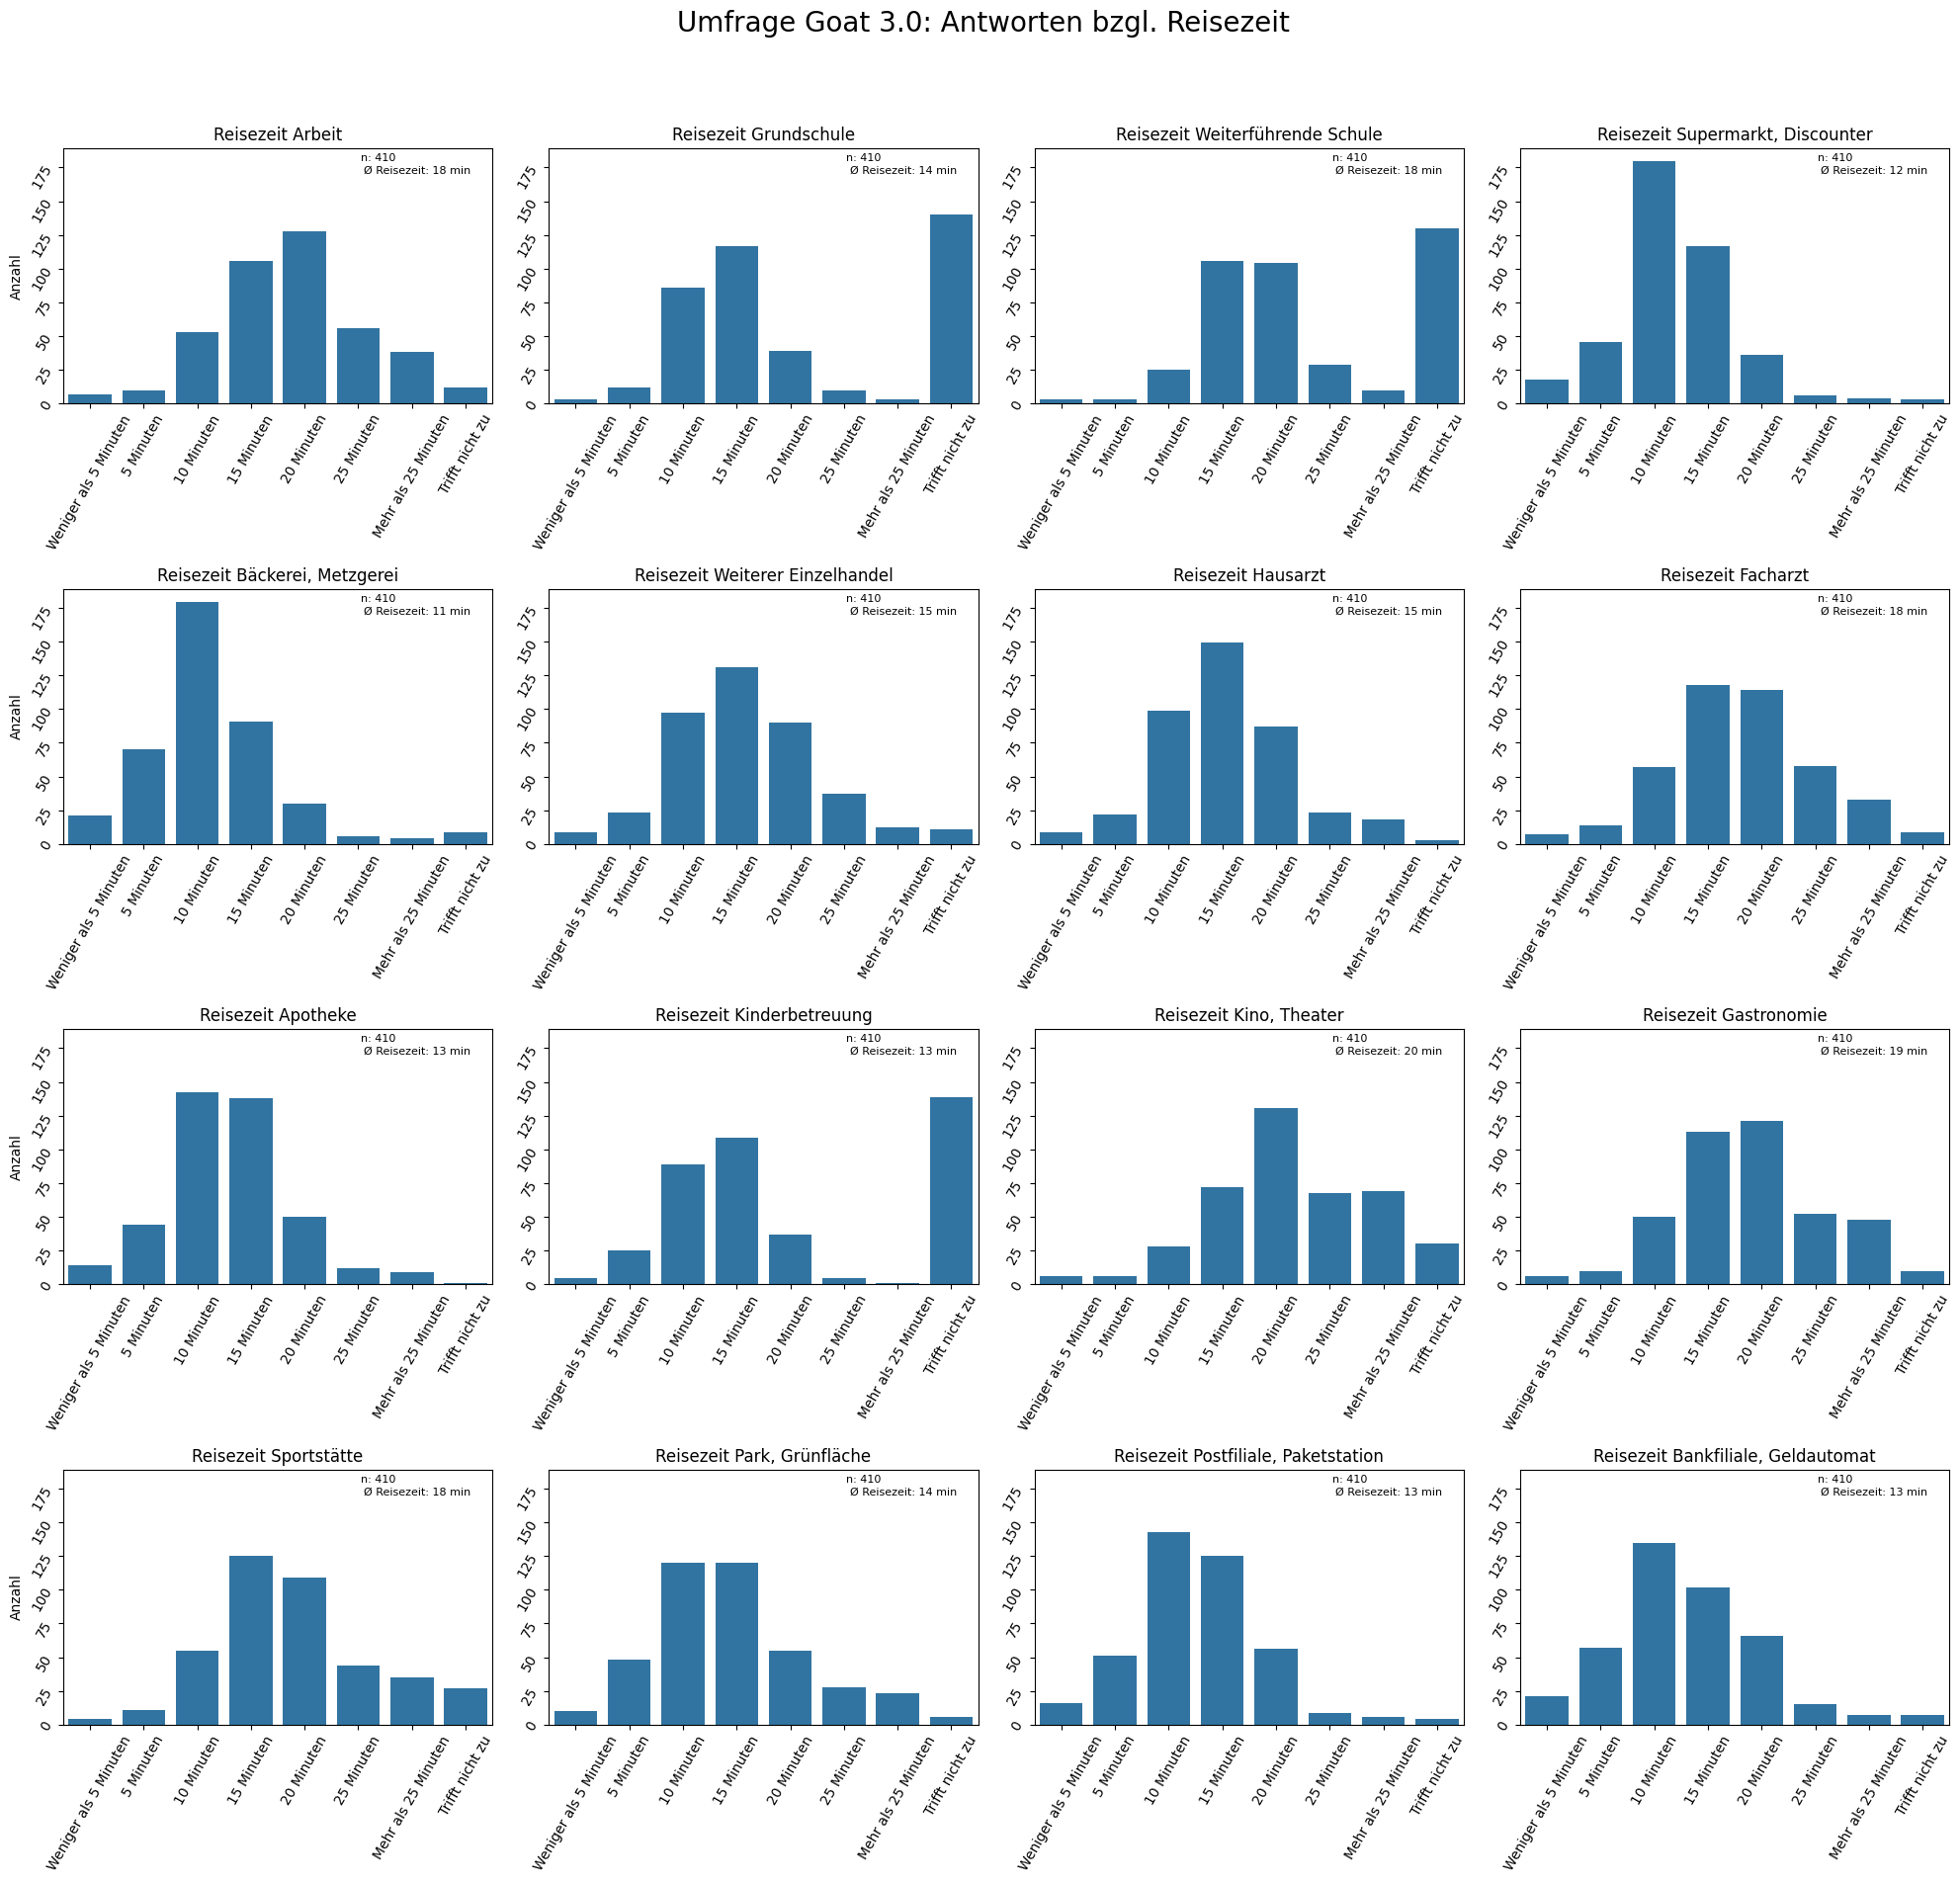

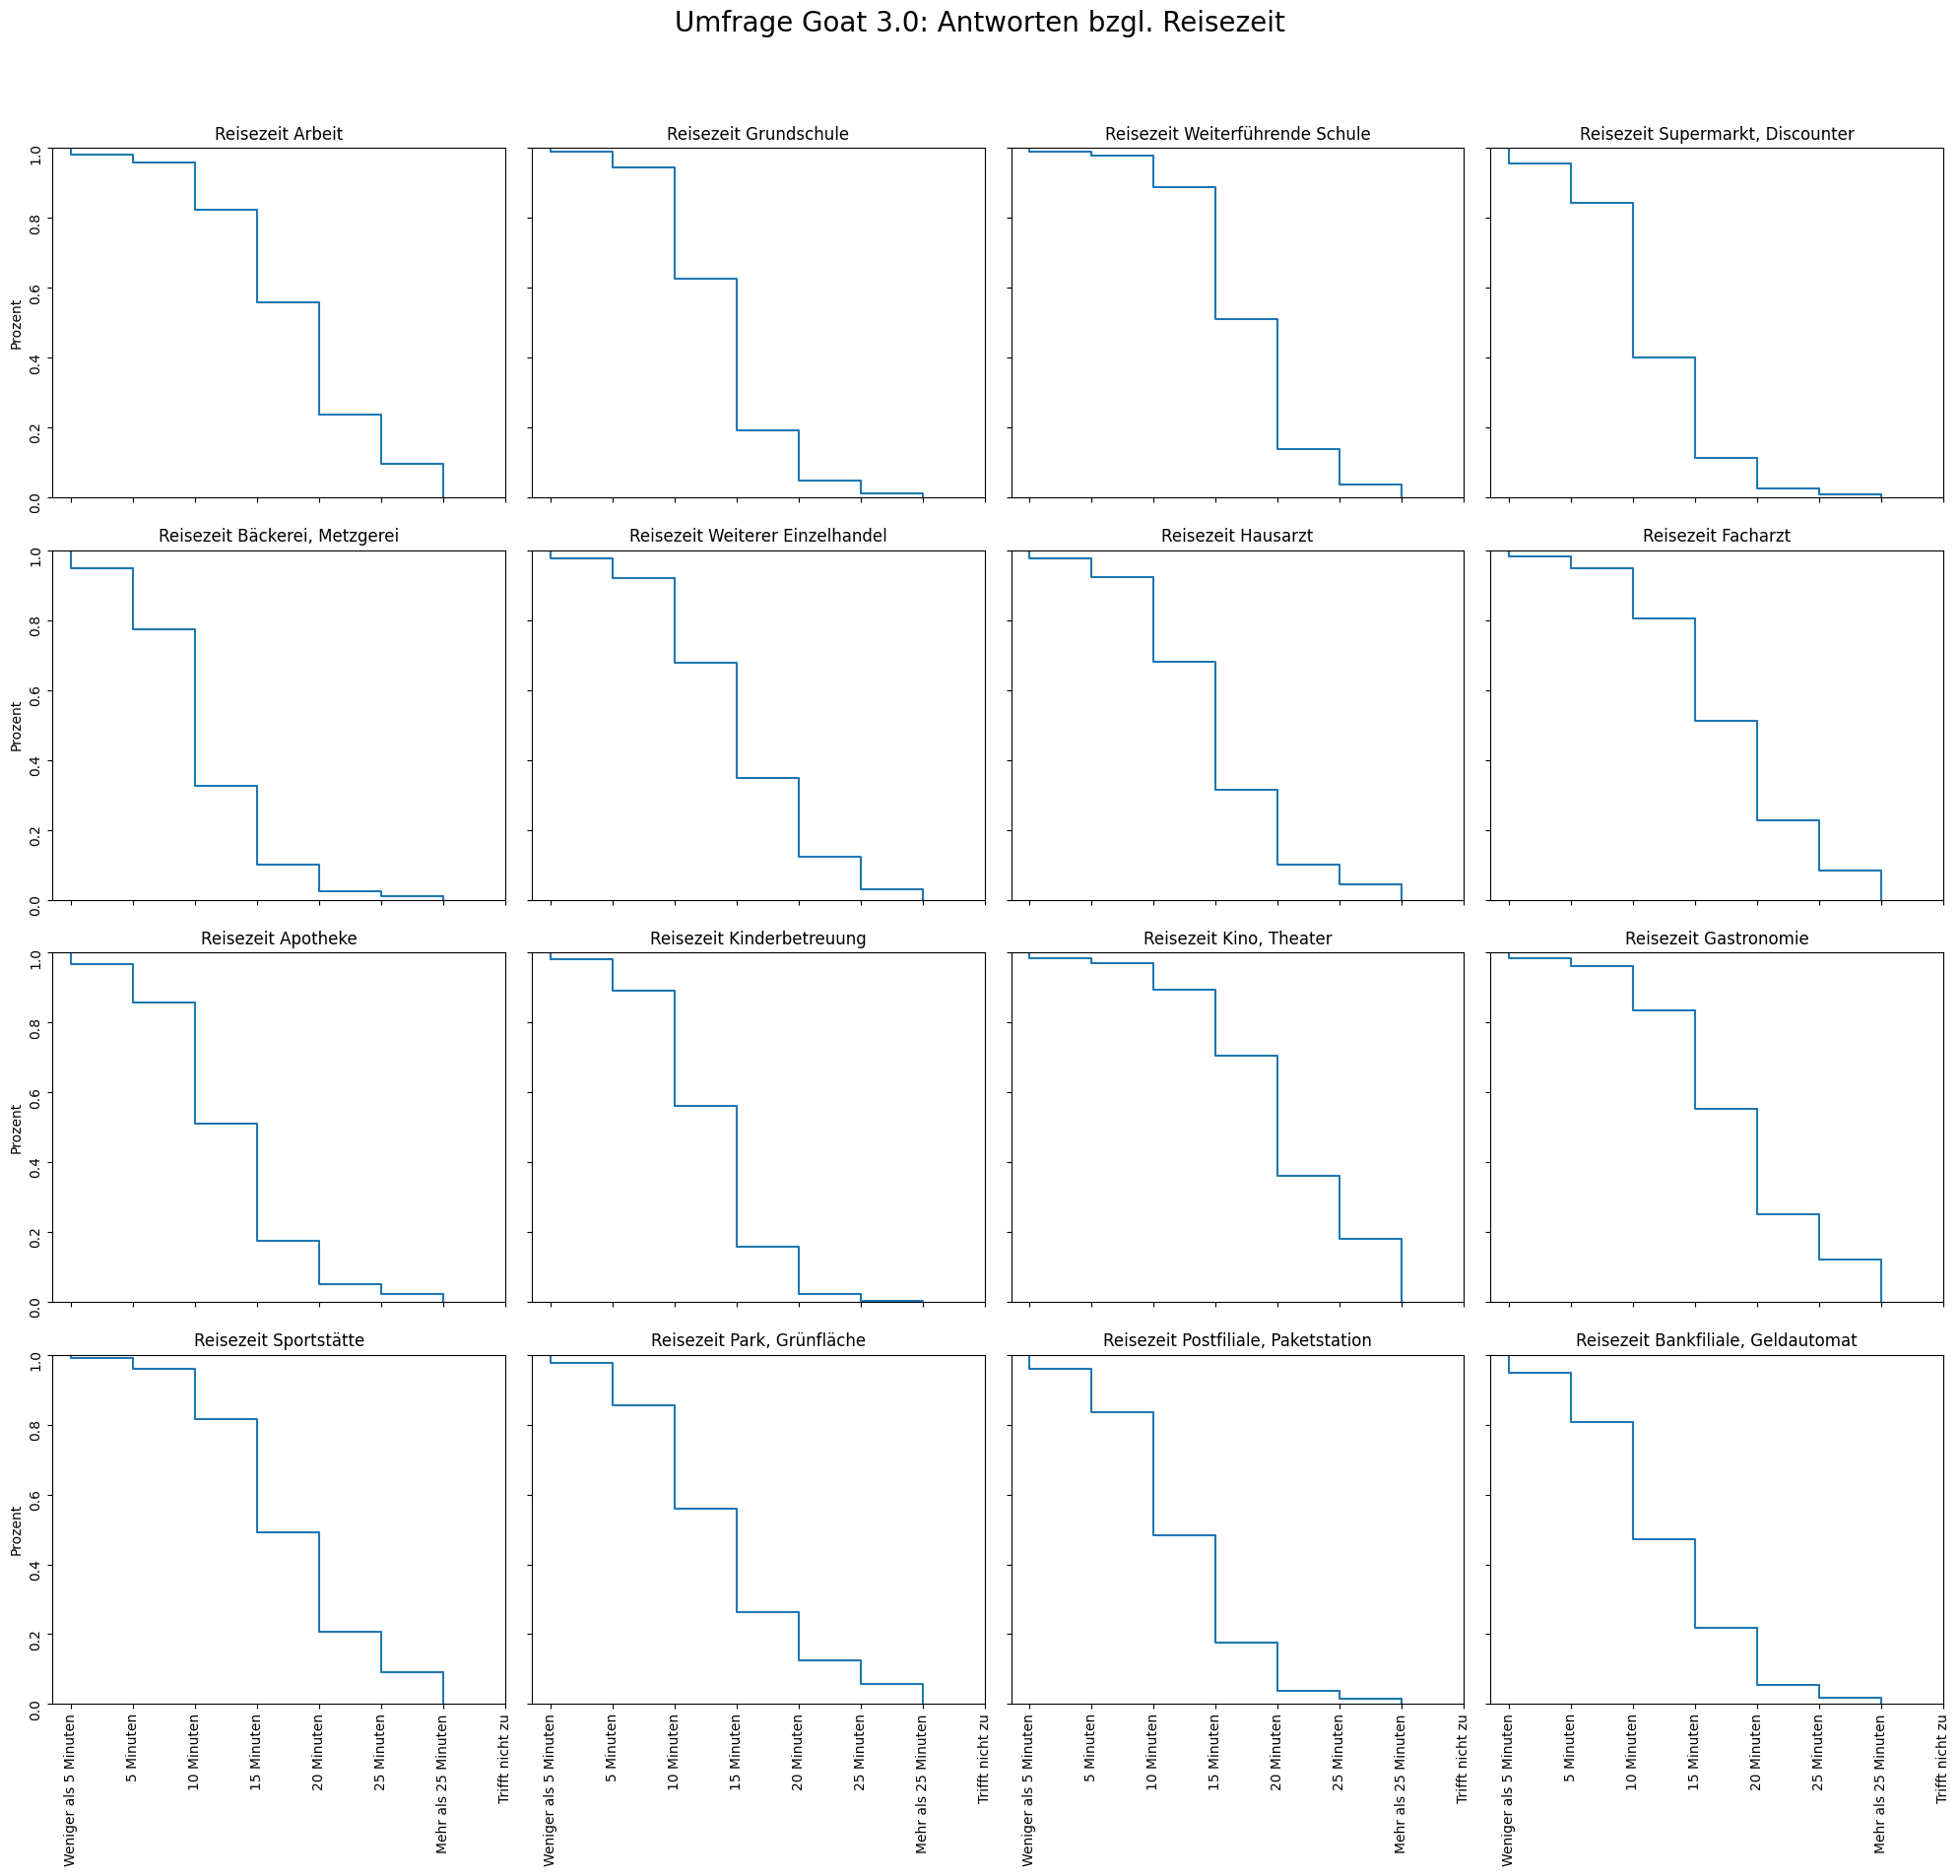

Reisezeit Arbeit: 9
Reisezeit Arbeit: Beta combined mod Gauß: 678,290
Reisezeit Grundschule: 8
Reisezeit Grundschule: Beta combined mod Gauß: 341,323
Reisezeit Weiterführende Schule: 12
Reisezeit Weiterführende Schule: Beta combined mod Gauß: 327,325
Reisezeit Supermarkt, Discounter: 6
Reisezeit Supermarkt, Discounter: Beta combined mod Gauß: 322,683
Reisezeit Bäckerei, Metzgerei: 5
Reisezeit Bäckerei, Metzgerei: Beta combined mod Gauß: 334,093
Reisezeit Weiterer Einzelhandel: 7
Reisezeit Weiterer Einzelhandel: Beta combined mod Gauß: 570,391
Reisezeit Hausarzt: 7
Reisezeit Hausarzt: Beta combined mod Gauß: 541,845
Reisezeit Facharzt: 9
Reisezeit Facharzt: Beta combined mod Gauß: 627,965
Reisezeit Apotheke: 6
Reisezeit Apotheke: Beta combined mod Gauß: 419,577
Reisezeit Kinderbetreuung: 7
Reisezeit Kinderbetreuung: Beta combined mod Gauß: 358,622
Reisezeit Kino, Theater: 11
Reisezeit Kino, Theater: Beta combined mod Gauß: 717,521
Reisezeit Gastronomie: 9
Reisezeit Gastronomie: Beta com

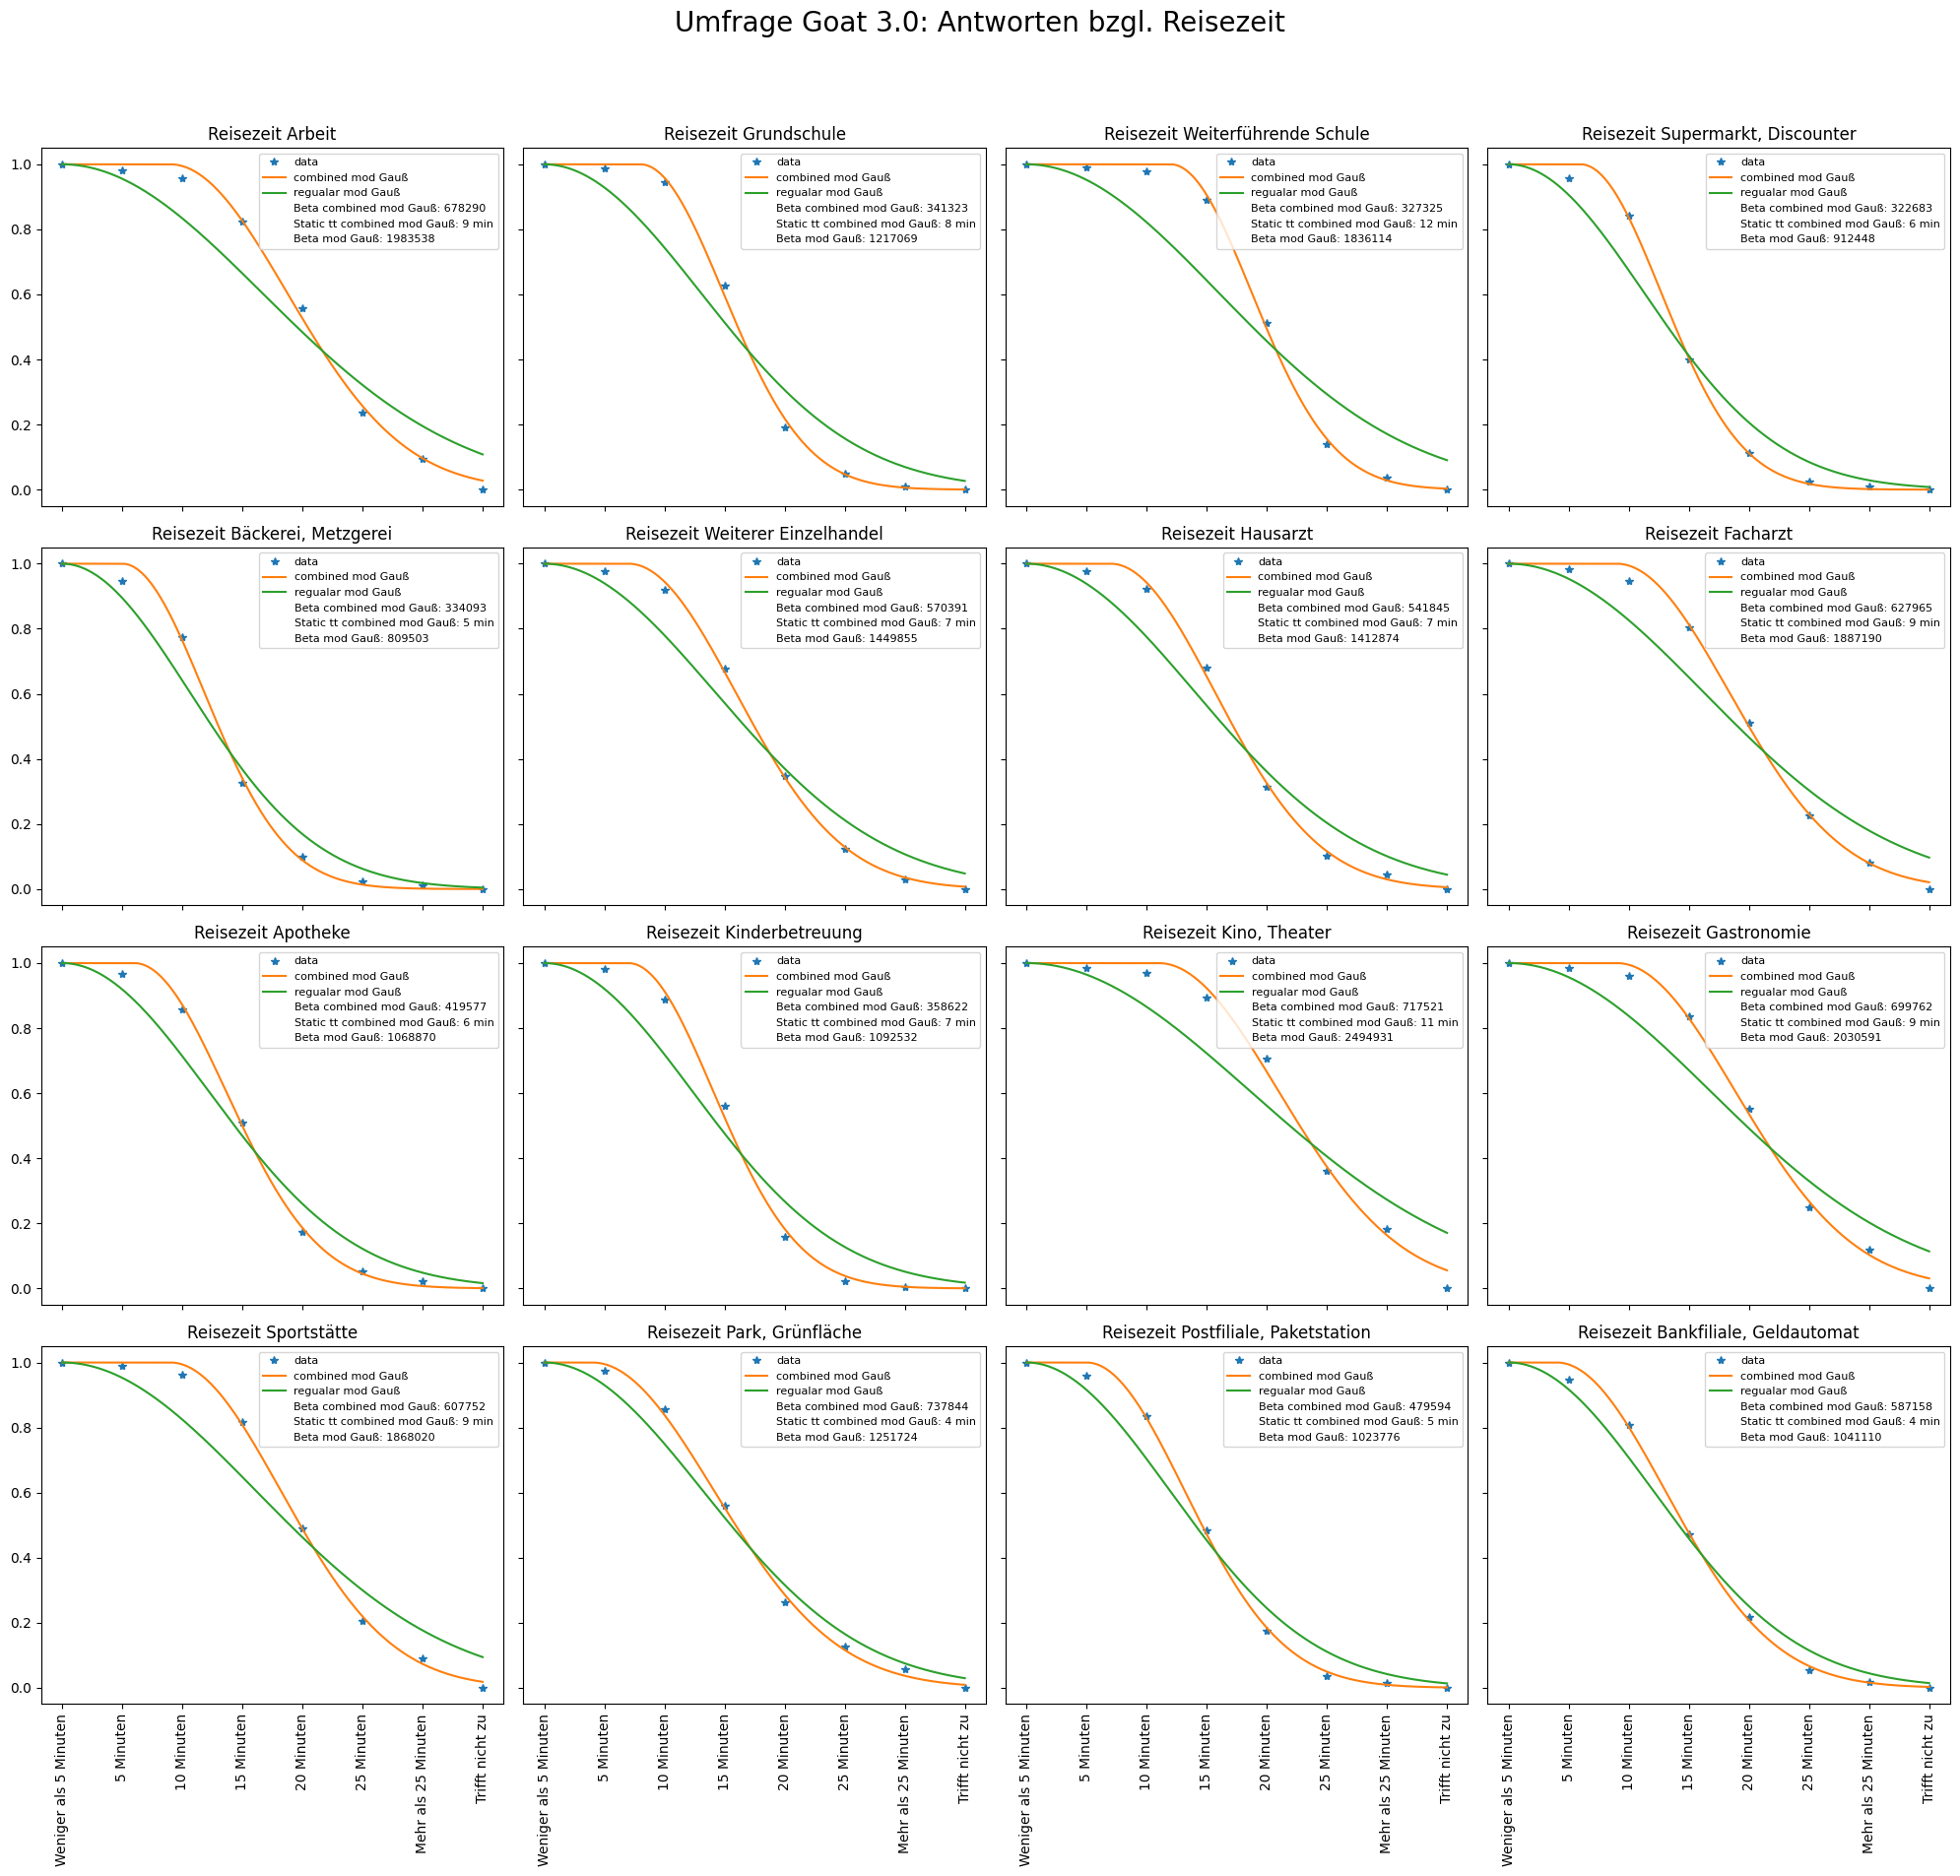

In [48]:
"""
Enter specific fragecode to plot the corresponding plots

fragecodes: 
'wegeidealfuss' -> questions regarding travelling on foot
'wegeidealrad' -> questions regarding travelling by bike
'reisezeit' -> questions regarding travel times by foot
'erreichbarkeitist' -> questions regarding the accessibility of a variety of destinations
'haeufigkeitist' ->  questions regarding the frequency of visiting a variety of destinations
'verkehrsmittelist' -> questions regarding the used means of transport to reach a specific destination
'nutzungdigital' ('haeufigkeitbestellen', 'nutzungdigital' (all except nutzungdigital[other]), 'alternativedigital') -> questions regarding the use of digital services
'wichtigkeit' ->  questions regarding the importance of a variety of destinations
'persoenliche_informationen' ('alter', 'geschlecht', 'haushalt', 'gesundheit' (1-5), 'taetigkeit') -> questions regarding personal information of the respondents
"""

create_subplots(fragecode = 'reisezeit' , df = survey_goat, df_metadata = survey_goat_metadata)


In [9]:
survey_goat.head()

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,startlocation,textideal,wegeidealfuss[SQ001],wegeidealfuss[SQ002],wegeidealfuss[SQ003],wegeidealfuss[SQ004],wegeidealfuss[SQ005],wegeidealfuss[SQ006],wegeidealfuss[SQ007],wegeidealfuss[SQ008],wegeidealfuss[SQ009],wegeidealfuss[SQ010],wegeidealrad[SQ001],wegeidealrad[SQ002],wegeidealrad[SQ003],wegeidealrad[SQ004],wegeidealrad[SQ005],wegeidealrad[SQ006],wegeidealrad[SQ007],wegeidealrad[SQ008],wegeidealrad[SQ009],wegeidealrad[SQ010],reisezeit[SQ001],reisezeit[SQ002],reisezeit[SQ003],reisezeit[SQ004],reisezeit[SQ005],reisezeit[SQ006],reisezeit[SQ007],reisezeit[SQ008],reisezeit[SQ009],reisezeit[SQ010],reisezeit[SQ011],reisezeit[SQ012],reisezeit[SQ013],reisezeit[SQ014],reisezeit[SQ015],reisezeit[SQ016],helpyesno3[SQ001],categoryinfo3,textalltag,erreichbarkeitist[SQ001],erreichbarkeitist[SQ002],erreichbarkeitist[SQ003],erreichbarkeitist[SQ004],erreichbarkeitist[SQ005],erreichbarkeitist[SQ006],erreichbarkeitist[SQ007],erreichbarkeitist[SQ008],erreichbarkeitist[SQ009],erreichbarkeitist[SQ010],erreichbarkeitist[SQ011],erreichbarkeitist[SQ012],erreichbarkeitist[SQ013],erreichbarkeitist[SQ014],erreichbarkeitist[SQ015],erreichbarkeitist[SQ016],haeufigkeitist[SQ001],haeufigkeitist[SQ002],haeufigkeitist[SQ003],haeufigkeitist[SQ004],haeufigkeitist[SQ005],haeufigkeitist[SQ006],haeufigkeitist[SQ007],haeufigkeitist[SQ008],haeufigkeitist[SQ009],haeufigkeitist[SQ010],haeufigkeitist[SQ011],haeufigkeitist[SQ012],haeufigkeitist[SQ013],haeufigkeitist[SQ014],haeufigkeitist[SQ015],haeufigkeitist[SQ016],verkehrsmittelist[SQ001],verkehrsmittelist[SQ002],verkehrsmittelist[SQ003],verkehrsmittelist[SQ004],verkehrsmittelist[SQ005],verkehrsmittelist[SQ006],verkehrsmittelist[SQ007],verkehrsmittelist[SQ008],verkehrsmittelist[SQ009],verkehrsmittelist[SQ010],verkehrsmittelist[SQ011],verkehrsmittelist[SQ012],verkehrsmittelist[SQ013],verkehrsmittelist[SQ014],verkehrsmittelist[SQ015],verkehrsmittelist[SQ016],dauerist,haeufigkeitbestellen,nutzungdigital[SQ001],nutzungdigital[SQ002],nutzungdigital[SQ003],nutzungdigital[SQ004],nutzungdigital[SQ005],nutzungdigital[SQ006],nutzungdigital[other],alternativedigital,wichtigkeit[SQ001],wichtigkeit[SQ002],wichtigkeit[SQ003],wichtigkeit[SQ004],wichtigkeit[SQ005],wichtigkeit[SQ006],wichtigkeit[SQ007],wichtigkeit[SQ008],wichtigkeit[SQ009],wichtigkeit[SQ010],wichtigkeit[SQ011],wichtigkeit[SQ012],wichtigkeit[SQ013],wichtigkeit[SQ014],wichtigkeit[SQ015],wichtigkeit[SQ016],alter,geschlecht,haushalt,gesundheit[SQ001],gesundheit[SQ002],gesundheit[SQ003],gesundheit[SQ004],gesundheit[SQ005],taetigkeit,yesempfnr,absenden
0,89,2022-03-29 14:09:00,14,de,1512300078,2022-03-29 13:57:18,2022-03-29 14:09:00,48.77081;9.17856,NaN,A4,A4,A3,A4,A4,A3,A4,A3,A3,A3,A4,A4,A3,A2,A4,A4,A2,A2,A4,A3,A5,A8,A8,A4,A4,A5,A4,A6,A2,A8,A5,A6,A6,A3,A2,A2,NaN,NaN,NaN,A2,A6,A2,A2,A2,A2,A6,A6,A2,A6,A6,A2,A6,A2,A1,A6,A4,A5,A5,A5,A5,A4,A3,A3,A3,A5,A5,A4,A3,A5,A4,A3,A3,A9,A9,A1,A1,A3,A3,A3,A1,A9,A9,A3,A3,A1,A1,A1,NaN,A3,Y,Y,Y,Y,NaN,NaN,NaN,A1,A2,A6,A6,A5,A5,A2,A4,A2,A5,A6,A2,A3,A3,A5,A4,A4,A3,A1,A2,NaN,NaN,NaN,Y,NaN,A1,NaN,NaN
1,90,2022-03-30 09:09:12,14,de,814438145,2022-03-30 08:59:18,2022-03-30 09:09:12,51.26532;7.20082,NaN,A3,A5,A5,A4,A2,A4,A3,A3,A4,A4,A3,A5,A5,A4,A2,A4,A2,A3,A4,A4,A5,A3,A4,A5,A5,A5,A5,A5,A5,A5,A5,A5,A5,A5,A5,A5,NaN,NaN,NaN,A4,A6,A6,A2,A2,A2,A3,A3,A1,A6,A2,A3,A3,A1,A3,A2,A5,A1,A1,A4,A4,A3,A2,A2,A2,A1,A2,A3,A4,A4,A3,A3,A2,A9,A9,A1,A1,A1,A3,A3,A1,A9,A3,A3,A3,A1,A1,A1,NaN,A3,Y,NaN,Y,NaN,NaN,NaN,NaN,A2,A4,A2,A2,A4,A4,A4,A3,A3,A3,A2,A3,A4,A4,A5,A3,A3,A3,A2,A2,NaN,NaN,NaN,Y,NaN,A1,NaN,NaN
2,92,2022-03-30 09:18:21,14,de,1592538828,2022-03-30 09:12:18,2022-03-30 09:18:21,48.15704;11.58766,NaN,A3,A4,A2,A4,A4,A3,A4,A4,A4,A3,A3,A4,A4,A4,A4,A4,A4,A4,A4,A3,A5,A4,A6,A4,A4,A4,A5,A5,A3,A4,A5,A4,A4,A5,A4,A3,NaN,NaN,NaN,A1,A1,A6,A1,A1,A1,A1,A1,A1,A1,A1,A1,A1,A1,A1,A1,A5,A5,A1,A4,A4,A3,A2,A2,A3,A5,A2,A3,A3,A4,A3,A3,A2,A1,A9,A2,A2,A2,A2,A4,A1,A2,A2,A1,A2,A1,A2,A2,NaN,A3,Y,NaN,NaN,NaN,NaN,NaN,NaN,A2,A3,A5,A5,A

In [10]:
import geopandas as gpd

In [11]:
# survey_goat_gdf.shape

In [12]:
survey_goat_gdf = gpd.GeoDataFrame(survey_goat.copy(), geometry=gpd.points_from_xy(survey_goat['startlocation'].str.split(';', 1).str[1].astype(float), survey_goat['startlocation'].str.split(';', 1).str[0].astype(float)), crs = 'EPSG:4326')
survey_goat_gdf.rename_geometry('geom', inplace = True)
survey_goat_gdf.drop(columns = ['startlocation'], inplace = True)

/tmp/ipykernel_1653206/3543133651.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  survey_goat_gdf = gpd.GeoDataFrame(survey_goat.copy(), geometry=gpd.points_from_xy(survey_goat['startlocation'].str.split(';', 1).str[1].astype(float), survey_goat['startlocation'].str.split(';', 1).str[0].astype(float)), crs = 'EPSG:4326')


In [13]:
survey_goat_gdf.columns

Index(['id', 'submitdate', 'lastpage', 'startlanguage', 'seed', 'startdate', 'datestamp', 'textideal', 'wegeidealfuss[SQ001]', 'wegeidealfuss[SQ002]',
       ...
       'haushalt', 'gesundheit[SQ001]', 'gesundheit[SQ002]', 'gesundheit[SQ003]', 'gesundheit[SQ004]', 'gesundheit[SQ005]', 'taetigkeit', 'yesempfnr', 'absenden', 'geom'], dtype='object', length=133)

In [14]:
# survey_goat_gdf.to_postgis(name = 'survey_goat_3_0', con = db_conn_datastore, schema = 'temporal',if_exists = 'replace', index = False)

In [15]:
# SQL Query to add the regiostar information to the survey data

# survey_goat_gdf = survey_goat_gdf.from_postgis(sql = "SELECT g.*, r.regiosta11 FROM temporal.survey_goat_3_0 g, municipality_county_regiostar_merge r WHERE ST_Intersects(r.the_geom, g.geom) AND r.the_geom && g.geom;", con = db_conn_datastore, geom_col = 'geom')


In [16]:
# survey_goat_gdf = survey_goat_gdf.from_postgis("select * from temporal.survey_goat_3_0", db_conn_datastore, geom_col = 'geom') 


In [17]:
# survey_goat_gdf['regiosta11'].value_counts()

In [18]:
# survey_goat_urban_gdf = survey_goat_gdf[survey_goat_gdf['regiosta11'].astype(str).str[0] == '1']
# survey_goat_rural_gdf = survey_goat_gdf[survey_goat_gdf['regiosta11'].astype(str).str[0] == '2']

In [19]:
# print(survey_goat_urban_gdf.shape)
# print(survey_goat_rural_gdf.shape)

In [20]:
# survey_goat.shape

In [21]:
# # gender of respondents living in cities
# # Weiblich: A1, Männlich: A2, Divers: A3, Keine Angabe: A4
# print(survey_goat_urban_gdf['geschlecht'].value_counts())

# survey_goat_urban_female_gdf = survey_goat_urban_gdf[survey_goat_urban_gdf['geschlecht'] == 'A1']
# survey_goat_urban_male_gdf = survey_goat_urban_gdf[survey_goat_urban_gdf['geschlecht'] == 'A2']

In [22]:
# # age of respondents living in cities
# # Bis 10 Jahre: A1, 11 bis 17 Jahre: A2, 18 bis 35 Jahre: A3, 36 bis 65 Jahre: A4, Älter als 65 Jahre: A5, Keine Angabe: A6
# print(survey_goat_urban_gdf['alter'].value_counts())

# survey_goat_young_adults_gdf = survey_goat_urban_gdf[survey_goat_urban_gdf['alter'] == 'A3']
# survey_goat_middle_aged_gdf = survey_goat_urban_gdf[survey_goat_urban_gdf['alter'] == 'A4']

In [23]:
# survey_goat_urban_gdf['taetigkeit'].value_counts()

In [24]:
# survey_goat_urban_gdf['haushalt'].value_counts()

In [25]:
# create_subplots(fragecode = 'reisezeit' , df = survey_goat, df_metadata = survey_goat_metadata)

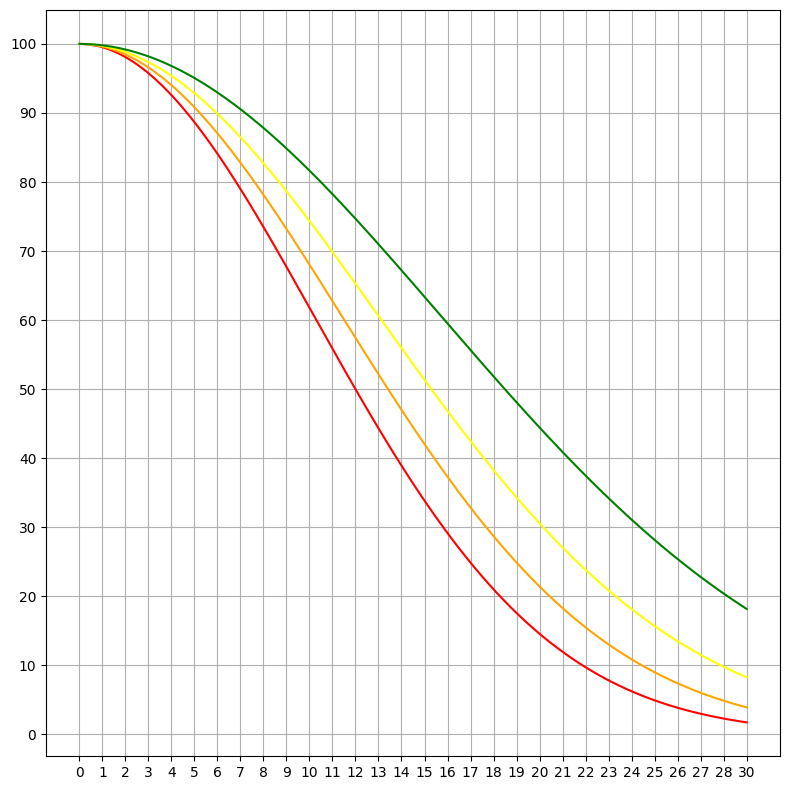

In [26]:
plt.figure(figsize=(8,8))
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), 800000), color = 'red')
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), 1000000), color = 'orange')
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), 1300000), color = 'yellow')
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), 1900000), color = 'green')
g.set_xticks(np.linspace(0, 30*60, 30, dtype = int))
g.set_xticklabels(np.linspace(0, 30, 30, dtype = int))
g.set_yticks(np.linspace(0, 1, 11))
g.set_yticklabels(np.linspace(0, 100, 11, dtype = int))
plt.grid()
plt.tight_layout()
plt.show()


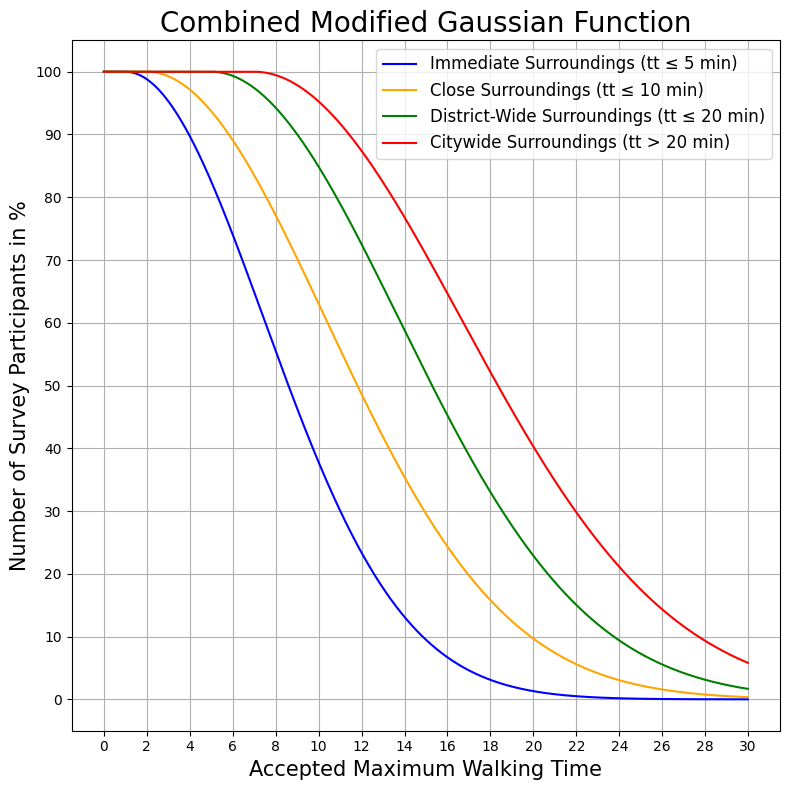

In [27]:
# walking and cycling acatech

plt.figure(figsize=(8,8))
plt.title('Combined Modified Gaussian Function', fontsize = 20)
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 300000, a = 1*60), color = 'blue', label = 'Immediate Surroundings (tt ≤ 5 min)')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 500000, a = (5 - 3)*60), color = 'orange', label = 'Close Surroundings (tt ≤ 10 min)')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 550000, a = (7.5 - 2.5)*60), color = 'green', label = 'District-Wide Surroundings (tt ≤ 20 min)')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 670000, a = (9.4 - 2.4)*60), color = 'red', label = 'Citywide Surroundings (tt > 20 min)')
# g.axvline(x=10*60, color='purple', linestyle='--')
# g.axvline(x=15*60, color='purple', linestyle='--')
# g.axvline(x=20*60, color='purple', linestyle='--')
g.set_xticks(np.linspace(0, 30*60, 16, dtype = int))
g.set_xticklabels(np.linspace(0, 30, 16, dtype = int))
g.set_yticks(np.linspace(0, 1, 11))
g.set_yticklabels(np.linspace(0, 100, 11, dtype = int))
g.legend(loc = 'upper right', fontsize = 12)
plt.xlabel('Accepted Maximum Walking Time', fontsize = 15)
plt.ylabel('Number of Survey Participants in %', fontsize = 15)
plt.grid()
plt.tight_layout()
plt.show()

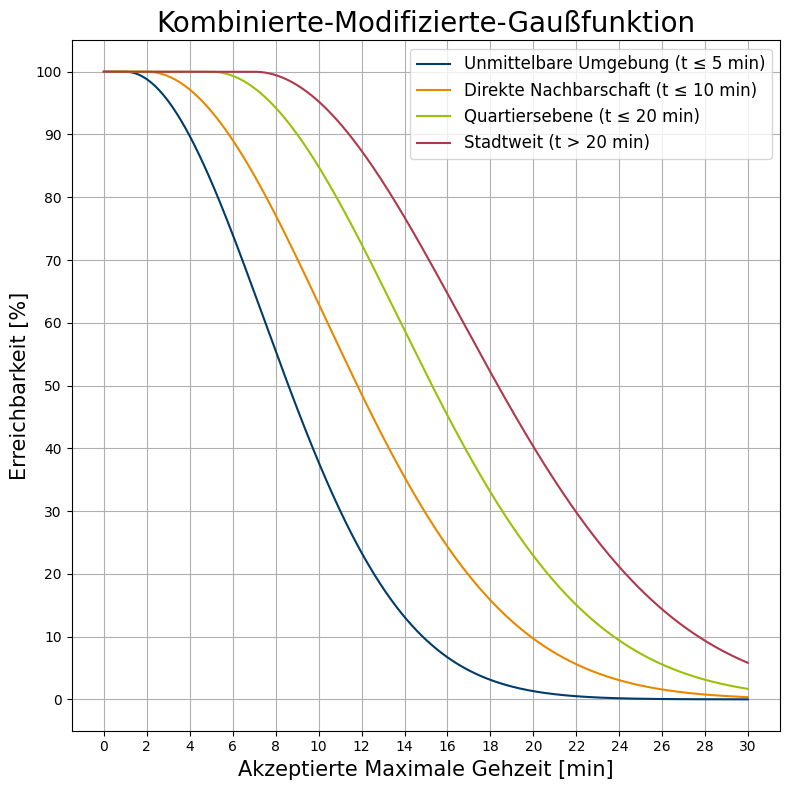

In [28]:
# walking and cycling acatech -> acatech Farben

plt.figure(figsize=(8,8))
plt.title('Kombinierte-Modifizierte-Gaußfunktion', fontsize = 20)
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 300000, a = 1*60), color = '#003c69', label = 'Unmittelbare Umgebung (t ≤ 5 min)')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 500000, a = (5 - 3)*60), color = '#E88800', label = 'Direkte Nachbarschaft (t ≤ 10 min)')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 550000, a = (7.5 - 2.5)*60), color = '#9AC00A', label = 'Quartiersebene (t ≤ 20 min)')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 670000, a = (9.4 - 2.4)*60), color = '#af384e', label = 'Stadtweit (t > 20 min)')
# g.axvline(x=10*60, color='purple', linestyle='--')
# g.axvline(x=15*60, color='purple', linestyle='--')
# g.axvline(x=20*60, color='purple', linestyle='--')
g.set_xticks(np.linspace(0, 30*60, 16, dtype = int))
g.set_xticklabels(np.linspace(0, 30, 16, dtype = int))
g.set_yticks(np.linspace(0, 1, 11))
g.set_yticklabels(np.linspace(0, 100, 11, dtype = int))
g.legend(loc = 'upper right', fontsize = 12)
plt.xlabel('Akzeptierte Maximale Gehzeit [min]', fontsize = 15)
plt.ylabel('Erreichbarkeit [%]', fontsize = 15)
plt.grid()
plt.tight_layout()
plt.show()

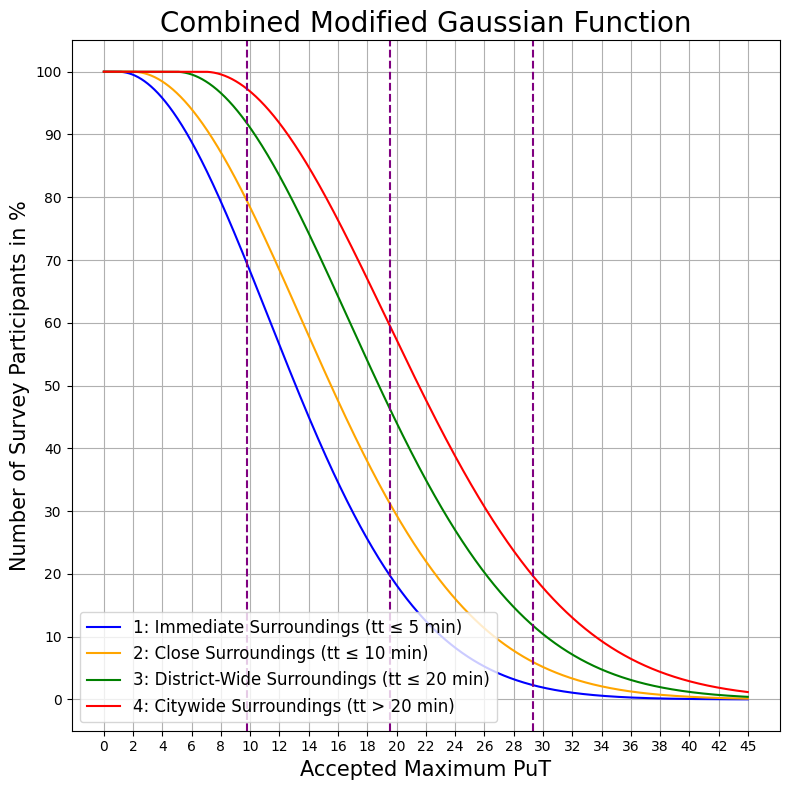

In [29]:
# PuT für acatech -> noch kalibrieren 

plt.figure(figsize=(8,8))
plt.title('Combined Modified Gaussian Function', fontsize = 20)
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 45*60, 45*60), b = (300000 + 500000), a = 1*60), color = 'blue', label = '1: Immediate Surroundings (tt ≤ 5 min)')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 45*60, 45*60), b = (500000 + 500000), a = (5 - 3)*60), color = 'orange', label = '2: Close Surroundings (tt ≤ 10 min)')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 45*60, 45*60), b = (550000 + 500000), a = (7.5 - 2.5)*60), color = 'green', label = '3: District-Wide Surroundings (tt ≤ 20 min)')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 45*60, 45*60), b = (670000 + 500000), a = (9.4 - 2.4)*60), color = 'red', label = '4: Citywide Surroundings (tt > 20 min)')
g.axvline(x=10*60, color='purple', linestyle='--')
g.axvline(x=20*60, color='purple', linestyle='--')
g.axvline(x=30*60, color='purple', linestyle='--')
g.set_xticks(np.linspace(0, 45*60, 23, dtype = int))
g.set_xticklabels(np.linspace(0, 45, 23, dtype = int))
g.set_yticks(np.linspace(0, 1, 11))
g.set_yticklabels(np.linspace(0, 100, 11, dtype = int))
g.legend(loc = 'lower left', fontsize = 12)
plt.xlabel('Accepted Maximum PuT', fontsize = 15)
plt.ylabel('Number of Survey Participants in %', fontsize = 15)
plt.grid()
plt.tight_layout()
plt.show()


In [30]:
comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 300000, a = (0)*60)

array([1.00000000e+00, 9.99996663e-01, 9.99986652e-01, ...,
       2.08950137e-05, 2.06458409e-05, 2.03995034e-05])

In [31]:
comb_modified_gaussian_fun(np.linspace(10*60, 30*60, 30*60), b = 300000, a = (0)*60)

array([3.01194212e-01, 3.00391207e-01, 2.99589453e-01, ...,
       2.07285820e-05, 2.05634149e-05, 2.03995034e-05])

In [32]:
np.linspace(0, 30*60, 30*60)

array([0.00000000e+00, 1.00055586e+00, 2.00111173e+00, ...,
       1.79799889e+03, 1.79899944e+03, 1.80000000e+03])

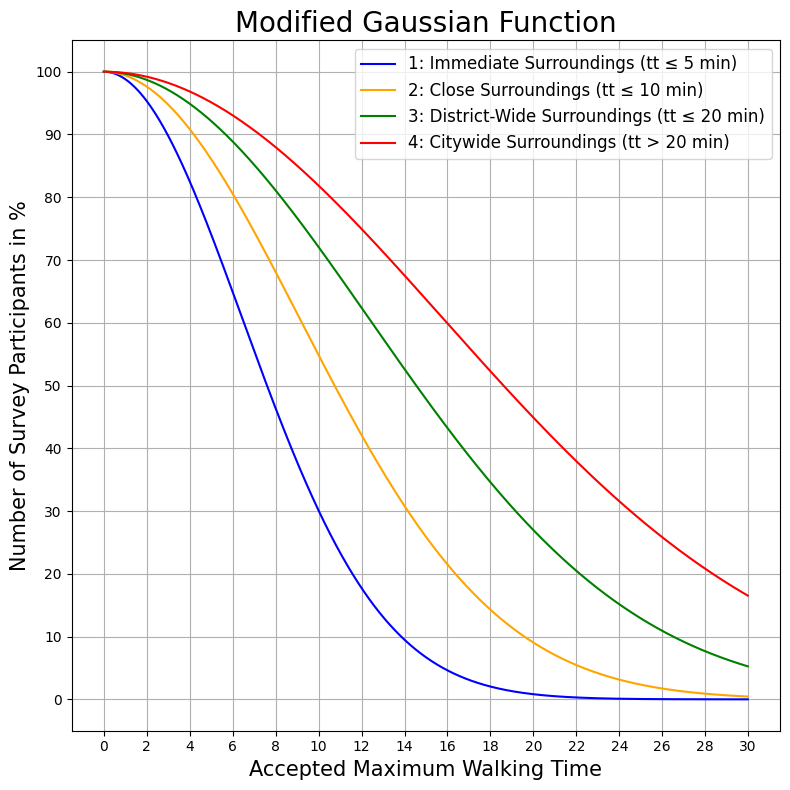

In [67]:
# angepasst
plt.figure(figsize=(8,8))
plt.title('Modified Gaussian Function', fontsize = 20)
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 300000), color = 'blue', label = '1: Immediate Surroundings (tt ≤ 5 min)')
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 600000), color = 'orange', label = '2: Close Surroundings (tt ≤ 10 min)')
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 1100000), color = 'green', label = '3: District-Wide Surroundings (tt ≤ 20 min)')
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 1800000), color = 'red', label = '4: Citywide Surroundings (tt > 20 min)')
g.set_xticks(np.linspace(0, 30*60, 16, dtype = int))
g.set_xticklabels(np.linspace(0, 30, 16, dtype = int))
g.set_yticks(np.linspace(0, 1, 11))
g.set_yticklabels(np.linspace(0, 100, 11, dtype = int))
g.legend(loc = 'upper right', fontsize = 12)
plt.xlabel('Accepted Maximum Walking Time', fontsize = 15)
plt.ylabel('Number of Survey Participants in %', fontsize = 15)
plt.grid()
plt.tight_layout()
plt.show()

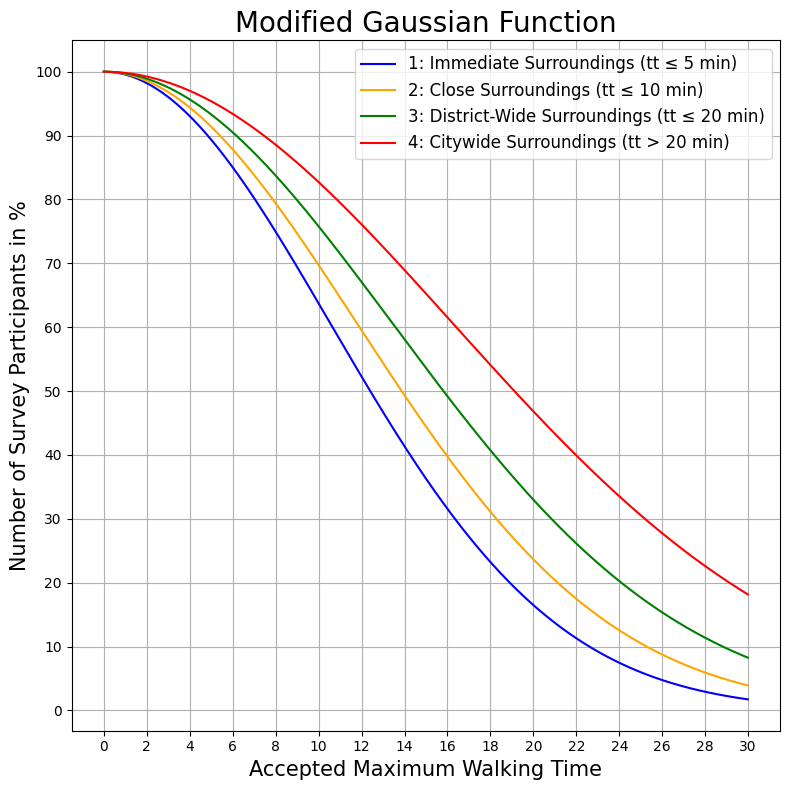

In [68]:
# Umfrage
plt.figure(figsize=(8,8))
plt.title('Modified Gaussian Function', fontsize = 20)
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 800000), color = 'blue', label = '1: Immediate Surroundings (tt ≤ 5 min)')
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 1000000), color = 'orange', label = '2: Close Surroundings (tt ≤ 10 min)')
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 1300000), color = 'green', label = '3: District-Wide Surroundings (tt ≤ 20 min)')
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 1900000), color = 'red', label = '4: Citywide Surroundings (tt > 20 min)')
g.set_xticks(np.linspace(0, 30*60, 16, dtype = int))
g.set_xticklabels(np.linspace(0, 30, 16, dtype = int))
g.set_yticks(np.linspace(0, 1, 11))
g.set_yticklabels(np.linspace(0, 100, 11, dtype = int))
g.legend(loc = 'upper right', fontsize = 12)
plt.xlabel('Accepted Maximum Walking Time', fontsize = 15)
plt.ylabel('Number of Survey Participants in %', fontsize = 15)
plt.grid()
plt.tight_layout()
plt.show()

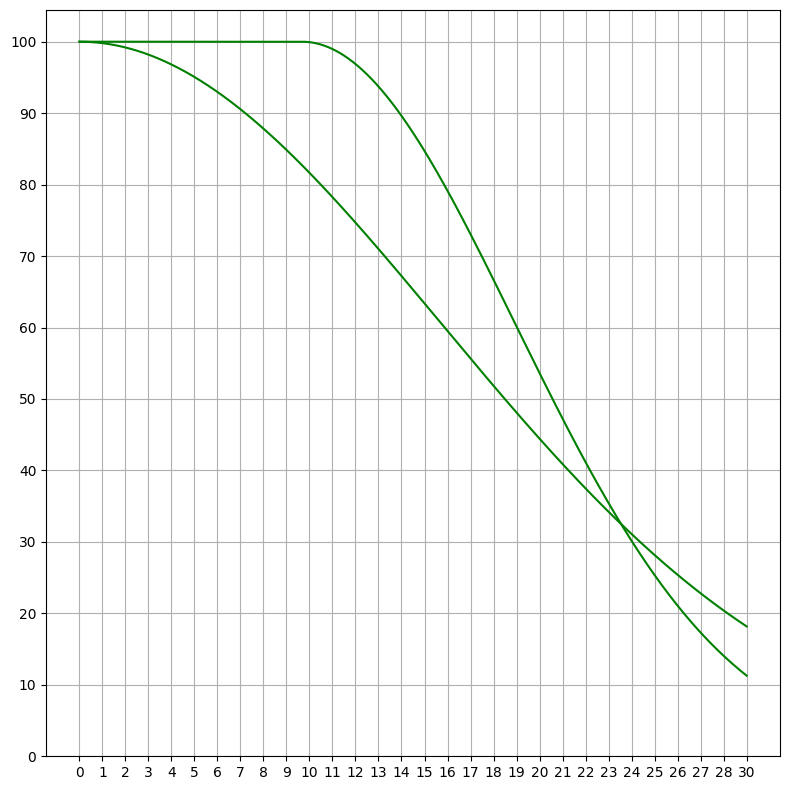

In [34]:
plt.figure(figsize=(8,8))
g = sns.lineplot(modified_gaussian_fun(np.linspace(0, 30*60, 30*60), 1900000), color = 'green')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 660000, a = 2*5*60), color = 'green')
g.set_xticks(np.linspace(0, 30*60, 30, dtype = int))
g.set_xticklabels(np.linspace(0, 30, 30, dtype = int))
g.set_yticks(np.linspace(0, 1, 11))
g.set_yticklabels(np.linspace(0, 100, 11, dtype = int))
plt.grid()
plt.tight_layout()
plt.show()


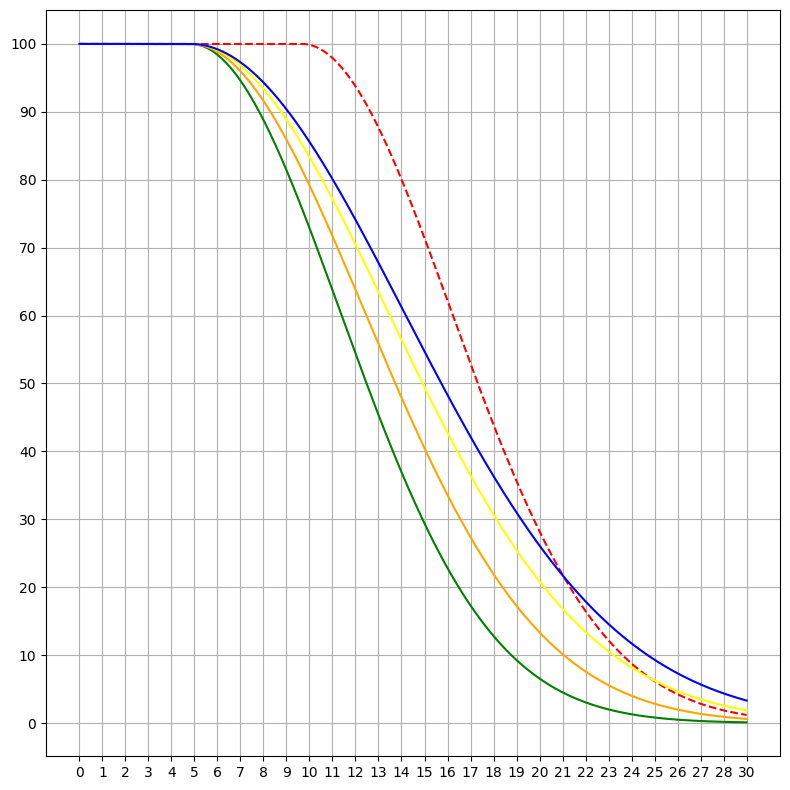

In [35]:
plt.figure(figsize=(8,8))
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 325000, a = 2*5*60), color = 'red', linestyle = '--')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 325000, a = 1*5*60), color = 'green')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 440000, a = 1*5*60), color = 'orange')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 565000, a = 1*5*60), color = 'yellow')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 660000, a = 1*5*60), color = 'blue')
g.set_xticks(np.linspace(0, 30*60, 30, dtype = int))
g.set_xticklabels(np.linspace(0, 30, 30, dtype = int))
g.set_yticks(np.linspace(0, 1, 11))
g.set_yticklabels(np.linspace(0, 100, 11, dtype = int))
plt.grid()
plt.tight_layout()
plt.show()

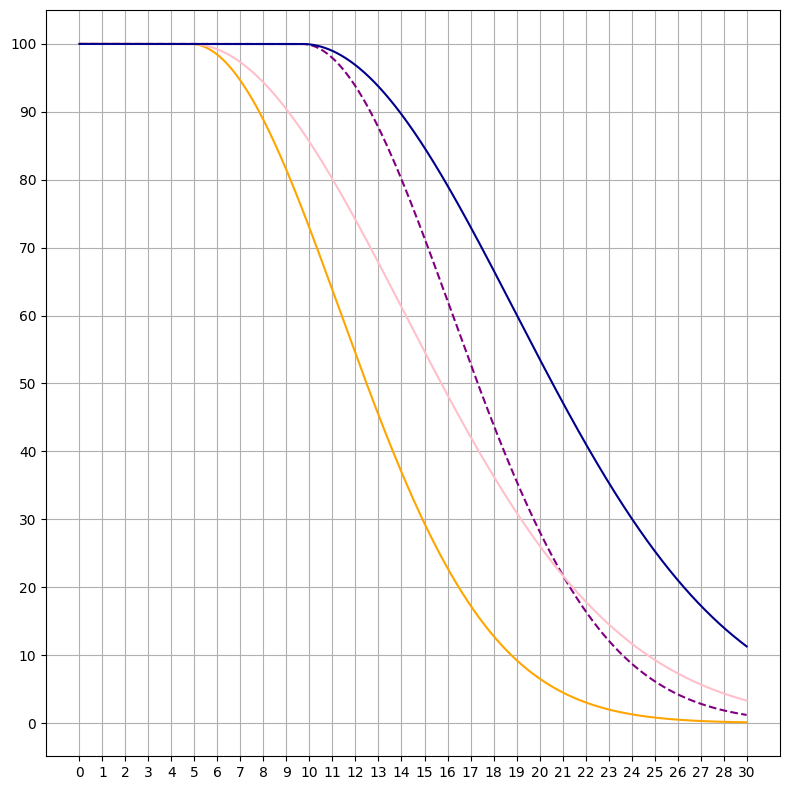

In [36]:
# weiterführende Schule
plt.figure(figsize=(8,8))
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 325000, a = 1*5*60), color = 'orange')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 325000, a = 2*5*60), color = 'purple', linestyle = '--')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 660000, a = 1*5*60), color = 'pink')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 660000, a = 2*5*60), color = 'darkblue')
g.set_xticks(np.linspace(0, 30*60, 30, dtype = int))
g.set_xticklabels(np.linspace(0, 30, 30, dtype = int))
g.set_yticks(np.linspace(0, 1, 11))
g.set_yticklabels(np.linspace(0, 100, 11, dtype = int))
plt.grid()
plt.tight_layout()
plt.show()

#  Sensitivity Parameters for Cycling

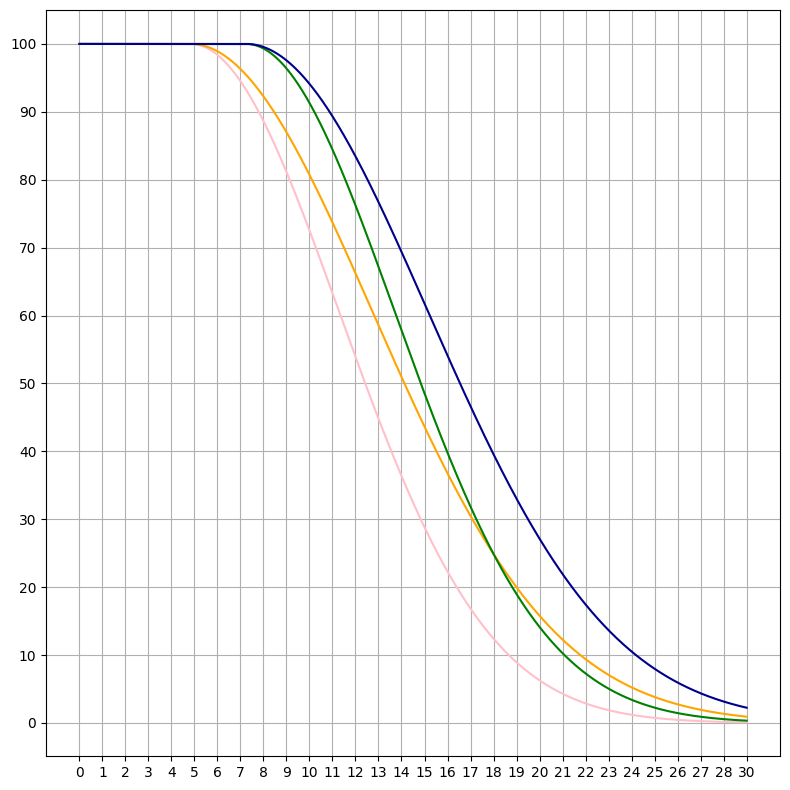

In [37]:
plt.figure(figsize=(8,8))
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 320000, a = 1*5*60), color = 'pink')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 1.5*320000, a = 1*5*60), color = 'orange')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 320000, a = 1.5*1*5*60), color = 'green')
g = sns.lineplot(comb_modified_gaussian_fun(np.linspace(0, 30*60, 30*60), b = 1.5*320000, a = 1.5*1*5*60), color = 'darkblue')
g.set_xticks(np.linspace(0, 30*60, 30, dtype = int))
g.set_xticklabels(np.linspace(0, 30, 30, dtype = int))
g.set_yticks(np.linspace(0, 1, 11))
g.set_yticklabels(np.linspace(0, 100, 11, dtype = int))
plt.grid()
plt.tight_layout()
plt.show()